# 2nd EXECUTION S10_T01
# STATEMENT
Level 3
- Exercise 6
Do not use the variable DepDelay when making predictions.

# **Here we finally delete the very dependent variable DepDelay.**

In [1]:
# Load libraries
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb ## One of the most popular machine learning algorithm
#Load Personal library
import Pers_lib as Pers # Import Personal functions ( my functions :) )
from sklearn.model_selection import GridSearchCV   #Performing grid search

# settings to display all columns (default is 20, now is None (all))
pd.set_option("display.max_columns", None)


In [2]:
# Load dataset
df = pd.read_csv('..\Data\DelayedFlights.csv')

# Data PreProcessing. 🤖

The same than before, but also deleting 'DepDelay':


In [4]:
# Delete columns that we find not relevant for our model.
try:
    # Let's clean first column that is repeated index.
    df = df.drop(columns ='Unnamed: 0')
    # Let's delete FlightNum and TailNum as these columns doesn't give us any useful information.
    df = df.drop(columns=['FlightNum','TailNum'])
    # Let's delete Origin and Dest as this info is already in Distance column.
    df = df.drop(columns=['Origin','Dest'])
    # Finally, let's drop the columns of Delays that are not ArrDelay, because ArrDelay is the sum of all others, and we don't think that 
    # the information of what kind of delay is, will be relevant, what is sure is that they are going to be completely dependent 
    # (the sum of them are equal to ArrDelay).
    df = df.drop(columns=['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'])
    # If we delete the NaN's, the Cancellation and Diverted Columns have been deleted.
    # That means that when whe have deleted NaN's registers, we have deleted the information of cancelled or diverted flights.  
    # As they were so few, is ok to delete them. But also they could be useful for another exploration. 
    # In other dataset / practice we could only extract the cancelled / diverted flights to arrive to interesting conclusions. 
    df = df.drop(columns=['Cancelled','CancellationCode','Diverted'])
    # In other dataset / practice we could only extract the cancelled / diverted flights to arrive to interesting conclusions. 
    df = df.drop(columns=['DepDelay'])
except:
    print("Columns already deleted")

# Drop all NaNs (as explained in S0901, the % of NaNs is very little in all the columns (0.4% max).   )
list_cols = df.columns
array_cols = list_cols.values
NumTotalRegisters = df.shape[0]
df = df.dropna(subset=array_cols)
print(f"Number of registers deleted are {NumTotalRegisters-df.shape[0]}")
print(f"% of registers with NaNs deleted are {((NumTotalRegisters-df.shape[0])/NumTotalRegisters)*100:.2f}%")

# Delete duplicates
index_dupl_df = df.duplicated()
print("Num. duplicates =", index_dupl_df.sum())
# As there are very few duplicates, we took them off.
df.drop_duplicates(inplace= True)

# Create column Date of the flight and delete the columns Year / Month / Day of Month. We keep DayOfWeek for potential correlations.
## Date of the flight
try:
    df['Date'] = pd.to_datetime(df.Year.astype(str)+'-'+ df.Month.astype(str)+'-'+ df.DayofMonth.astype(str))
    df = df.drop(columns=['Year','Month','DayofMonth'])
except:
    print("Date column already created and columns Year, Month & DayofMonth already deleted")


Number of registers deleted are 8387
% of registers with NaNs deleted are 0.43%
Num. duplicates = 3


Finally, we are going to sample our data, a total of 1% random, stratifying by airline.

In [6]:
NumTotalRegisters = df.shape[0]
NumTotalRegisters
TotalSample = NumTotalRegisters * 0.01
AirlinesCounts = pd.DataFrame(df.UniqueCarrier.value_counts())
AirlinesCounts['Proportion']=AirlinesCounts['UniqueCarrier'] / NumTotalRegisters
AirlinesCounts['Samples'] = round(AirlinesCounts.Proportion *TotalSample)

df_sample = pd.DataFrame()
for Airline in AirlinesCounts.index:
    NumSamples = int(AirlinesCounts.loc[[Airline],:].Samples)
    df_sample = df_sample.append(df[df.UniqueCarrier == Airline].sample(NumSamples,random_state=1))

Finally, let's plot the correlation matrix of all the variables.

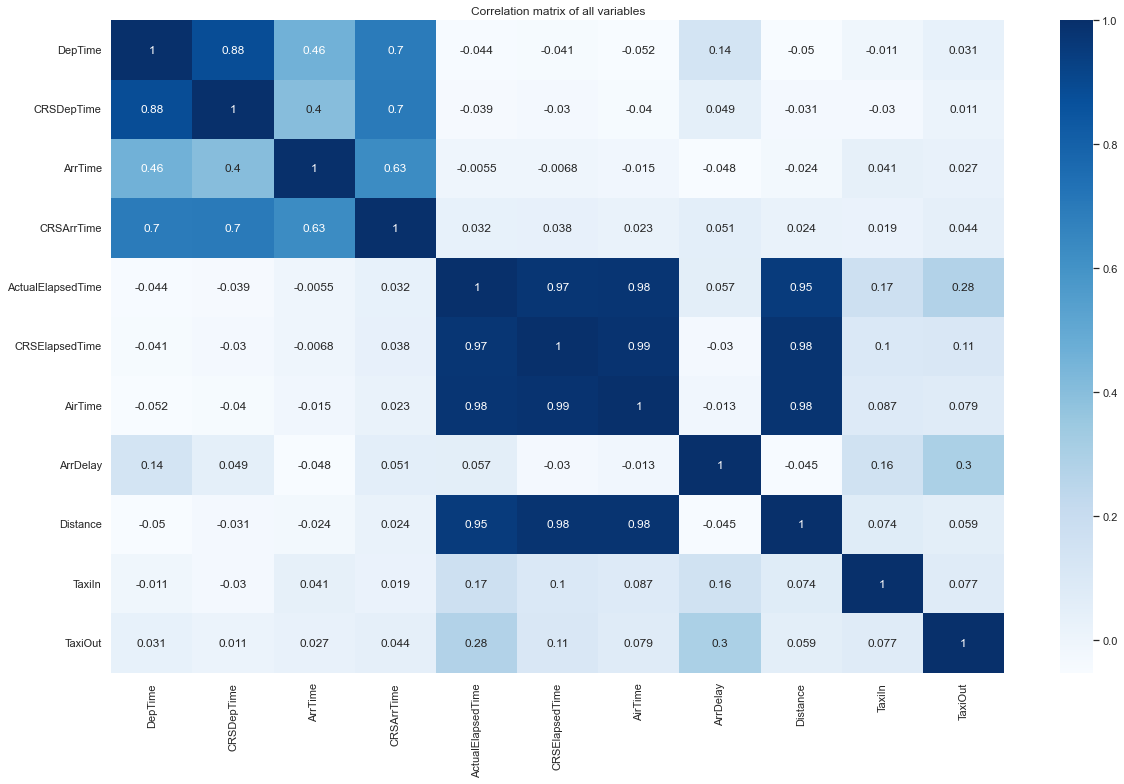

In [9]:
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('Correlation matrix of all variables')
corrMatrix = df_graph.corr()
sns.heatmap(corrMatrix, annot=True, cmap="Blues")
plt.show()

Here we see that our target **ArrDelay** now doesn't have a very clear dependency with any of our features, max is 0.3 with TaxiOut.  
Let's continue with our pre-processing process.

Finally, let's standardize all numerical columns and OHE the Carrier column.

In [12]:
# Standardize df_train
# list for cols to scale (all except for day of week).
cols_to_scale = df_sample._get_numeric_data().columns
cols_to_scale = cols_to_scale.drop('DayOfWeek')
# create and fit scaler
scaler = StandardScaler()
scaler.fit(df_sample[cols_to_scale])
# scale selected data
df_sample[cols_to_scale] = scaler.transform(df_sample[cols_to_scale])
# Show head df
df_sample.head()

DayOfWeek   DepTime  CRSDepTime   ArrTime  CRSArrTime UniqueCarrier  \
1533757          4  0.466659    0.431571  0.425856    0.381125            WN   
1103252          3  0.893527    0.917609  0.777651    0.823735            WN   
591899           7  1.190770    1.344375  1.087303    1.115209            WN   
593783           2  0.240933    0.360444  0.552282    0.586237            WN   
903004           3  0.947165    1.071719  0.805135    0.845325            WN   

         ActualElapsedTime  CRSElapsedTime   AirTime  ArrDelay  Distance  \
1533757          -0.795755       -0.761680 -0.760614 -0.142721 -0.688341   
1103252          -0.781888       -0.761680 -0.658966 -0.384707 -0.627480   
591899           -0.837358       -0.831776 -0.717051 -0.496393 -0.676169   
593783           -0.379729       -0.411204 -0.324977 -0.626693 -0.154505   
903004           -0.906696       -0.971966 -0.862263 -0.291635 -0.843101   

           TaxiIn   TaxiOut       Date  
1533757  0.789406 -0.649418 2008-10-16  
1103252 -0.340641 -0.649418 2008-07-23  
591899  -0.905665 -0.437526 2008-04-20  
593783  -0.340641 -0.225635 2008-04-22  
903004  -0.905665 -0.084373 2008-06-18

In [13]:
# Get dummies of all unique values of attribute UniqueCarrier.
df_sample = pd.get_dummies(df_sample,columns=['UniqueCarrier'])
df_sample.head()

DayOfWeek   DepTime  CRSDepTime   ArrTime  CRSArrTime  \
1533757          4  0.466659    0.431571  0.425856    0.381125   
1103252          3  0.893527    0.917609  0.777651    0.823735   
591899           7  1.190770    1.344375  1.087303    1.115209   
593783           2  0.240933    0.360444  0.552282    0.586237   
903004           3  0.947165    1.071719  0.805135    0.845325   

         ActualElapsedTime  CRSElapsedTime   AirTime  ArrDelay  Distance  \
1533757          -0.795755       -0.761680 -0.760614 -0.142721 -0.688341   
1103252          -0.781888       -0.761680 -0.658966 -0.384707 -0.627480   
591899           -0.837358       -0.831776 -0.717051 -0.496393 -0.676169   
593783           -0.379729       -0.411204 -0.324977 -0.626693 -0.154505   
903004           -0.906696       -0.971966 -0.862263 -0.291635 -0.843101   

           TaxiIn   TaxiOut       Date  UniqueCarrier_9E  UniqueCarrier_AA  \
1533757  0.789406 -0.649418 2008-10-16                 0                 0   
1103252 -0.340641 -0.649418 2008-07-23                 0                 0   
591899  -0.905665 -0.437526 2008-04-20                 0                 0   
593783  -0.340641 -0.225635 2008-04-22                 0                 0   
903004  -0.905665 -0.084373 2008-06-18                 0                 0   

         UniqueCarrier_AQ  UniqueCarrier_AS  UniqueCarrier_B6  \
1533757                 0                 0                 0   
1103252                 0                 0                 0   
591899                  0                 0                 0   
593783                  0                 0                 0   
903004                  0                 0                 0   

         UniqueCarrier_CO  UniqueCarrier_DL  UniqueCarrier_EV  \
1533757                 0                 0                 0   
1103252                 0                 0                 0   
591899                  0                 0                 0   
593783                  0                 0                 0   
903004                  0                 0                 0   

         UniqueCarrier_F9  UniqueCarrier_FL  UniqueCarrier_HA  \
1533757                 0                 0                 0   
1103252                 0                 0                 0   
591899                  0                 0                 0   
593783                  0                 0                 0   
903004                  0                 0                 0   

         UniqueCarrier_MQ  UniqueCarrier_NW  UniqueCarrier_OH  \
1533757                 0                 0                 0   
1103252                 0                 0                 0   
591899                  0                 0                 0   
593783                  0                 0                 0   
903004                  0                 0                 0   

         UniqueCarrier_OO  UniqueCarrier_UA  UniqueCarrier_US  \
1533757                 0                 0                 0   
1103252                 0                 0                 0   
591899                  0                 0                 0   
593783                  0                 0                 0   
903004                  0                 0                 0   

         UniqueCarrier_WN  UniqueCarrier_XE  UniqueCarrier_YV  
1533757                 1                 0                 0  
1103252                 1                 0                 0  
591899                  1                 0                 0  
593783                  1                 0                 0  
903004                  1                 0                 0

# Level 1

## - Exercise 1 
Create at least three different classification models to try to predict as well as possible the delay of the flights (ArrDelay) of DelayedFlights.csv.  
Consider whether the flight has arrived late or not (ArrDelay > 0).

## - Exercise 2
Compare the classification models using accuracy, a confidence matrix and other more advanced metrics.

## - Exercise 3
Train them using the different parameters they admit.

## - Exercise 4
Compare their performance using the trait/test or cross-validation approach.

### 1.1.- Decision Tree Classification

Let's define all numerical columns as independent or feature variables (X) except **ArrDelay** (otherwise model is completely dependent, of course)

In [14]:
feature_cols = df_sample._get_numeric_data().columns
feature_cols = feature_cols.drop('ArrDelay')
X = df_sample[feature_cols]

Let's create the 'Delayed' column and declare it as dependent or target variable (y).

In [15]:
df_sample['Delayed'] = (df_sample['ArrDelay']> 0)
print("Number of flights Delayed are",df_sample['Delayed'].sum(),"of",len(df_sample))
df_sample.head()

y = df_sample['Delayed']

Number of flights Delayed are 6427 of 19283


Split dataset into training set and test set


In [16]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test|

### 1.1.1.- Create and Visualize Decision Tree Model

In [17]:
# Create Decision Tree classifier object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifier
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


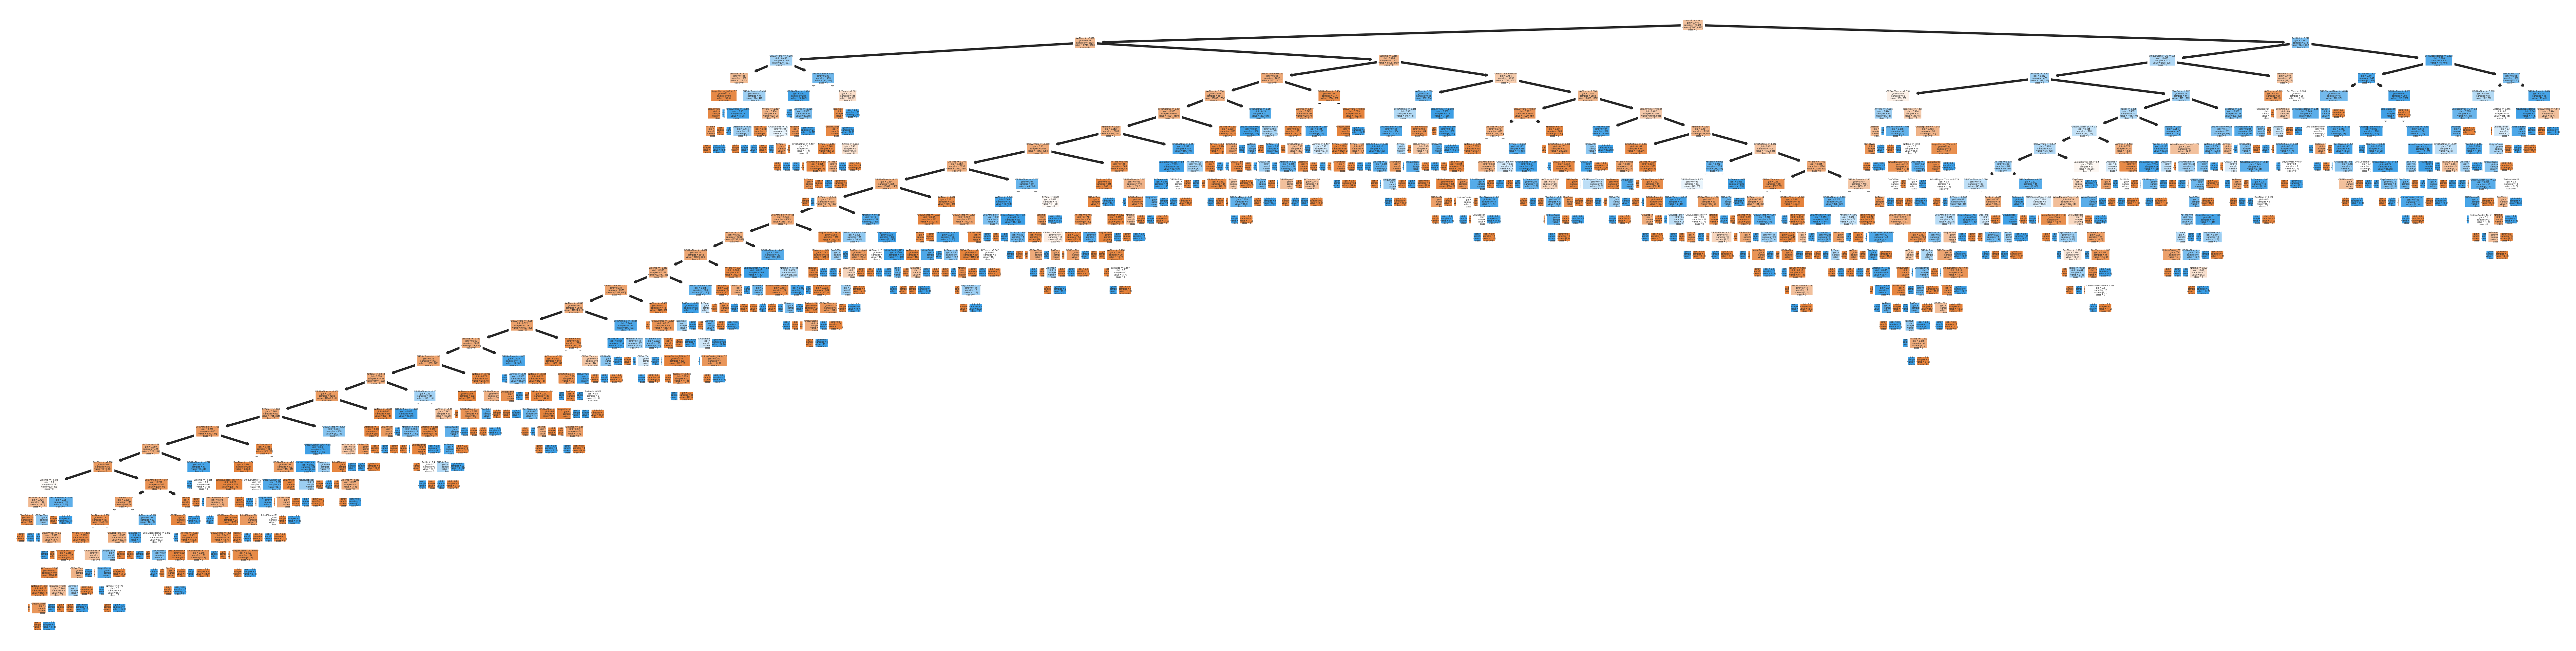

In [18]:
# Visualize Model

plt.figure(figsize=(20, 5), dpi=500)
tree.plot_tree(clf,
               feature_names=feature_cols,
               class_names=["0", "1"],
               filled=True,
               rounded=True);

### 1.1.2.- Evaluate Decision Tree Model

- **Confusion Matrix**  
For any dataset containing binary outcomes, we can label all observations with a 1 (indicating the occurrence of an event) or 0 (the absence of an event).   
We can fit a model to the feature variables and make a prediction for each observation given the set of feature variables. Values that are correctly classified by the model are labelled true (T), while incorrect predictions are false (F). Positive (P) and negative (N) refer to the model’s prediction, as opposed to the actual value of the observation. For example, a negative value incorrectly classified as positive is called a false positive.  
![](2022-03-17-08-52-53.png)  

- **Accuracy**
In a more technical sense, the value for accuracy can be obtained from the confusion matrix quite easily, as the number of true positives and true negatives divided by the total number of observations tested on.   
In simpler terms, it’s the proportion of observations correctly classified.  
$Accuracy = (TP + TN) / (TP + TN + FP + FN)$

- **Sensitivity**
$Sensitivity = TP / (TP + FN)$
- **F1 Score**
Last but not least, the F1 score summarizes both precision and recall and can be understood as the harmonic mean of the two measures.  
An F1 score of 1 indicates perfect precision and recall, therefore the higher the F1 score, the better the model.  
$F1 = 2 * (Precision * Sensitivity) / (Precision + Sensitivity)$

In [19]:
# Evaluate the model:
# Confusion matrix.
print(metrics.confusion_matrix(y_test, y_pred))
# Classification Report
print(metrics.classification_report(y_test, y_pred))

[[3774  122]
 [ 152 1737]]
              precision    recall  f1-score   support

       False       0.96      0.97      0.96      3896
        True       0.93      0.92      0.93      1889

    accuracy                           0.95      5785
   macro avg       0.95      0.94      0.95      5785
weighted avg       0.95      0.95      0.95      5785



### 1.1.3.- Optimizing Decision Tree Performance

- **criterion :  optional (default=”gini”) or Choose attribute selection measure**: This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

-  **splitter : {"best", "random"}, default="best"**
        The strategy used to choose the split at each node. Supported
        strategies are "best" to choose the best split and "random" to choose
        the best random split.
- **splitter : string, optional (default=”best”) or Split Strategy**: This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

- **max_depth : int or None, optional (default=None) or Maximum Depth of a Tree**: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting ([Source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)).


In [20]:
# Create Decision Tree classifier object
clf = DecisionTreeClassifier(criterion="entropy",splitter="random" ,max_depth=4)

# Train Decision Tree Classifier
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Evaluate the model:
# Confusion matrix.
print(metrics.confusion_matrix(y_test, y_pred))
# Classification Report
print(metrics.classification_report(y_test, y_pred))

[[3841   55]
 [1530  359]]
              precision    recall  f1-score   support

       False       0.72      0.99      0.83      3896
        True       0.87      0.19      0.31      1889

    accuracy                           0.73      5785
   macro avg       0.79      0.59      0.57      5785
weighted avg       0.76      0.73      0.66      5785



#### Observation:
In this case, the optimization give us a negative result.  
The resultant model is worse than the original, more changes or auto-tuning should be done.

### 1.1.4.- Compare Decision Tree Performance using the trait/test or cross-validation approach.

In [21]:
#Let's concatenate train & test
X_complete = pd.concat([X_train,X_test])
print("X shape:",X_complete.shape)
y_complete = pd.concat([y_train,y_test])
print("y shape:",y_complete.shape)

X shape: (19283, 31)
y shape: (19283,)


In [22]:
# Create Decision Tree classifier object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifier
clf = clf.fit(X_complete,y_complete)

#Predict the response for complete dataset
y_pred = clf.predict(X_complete)
y_pred.shape


(19283,)

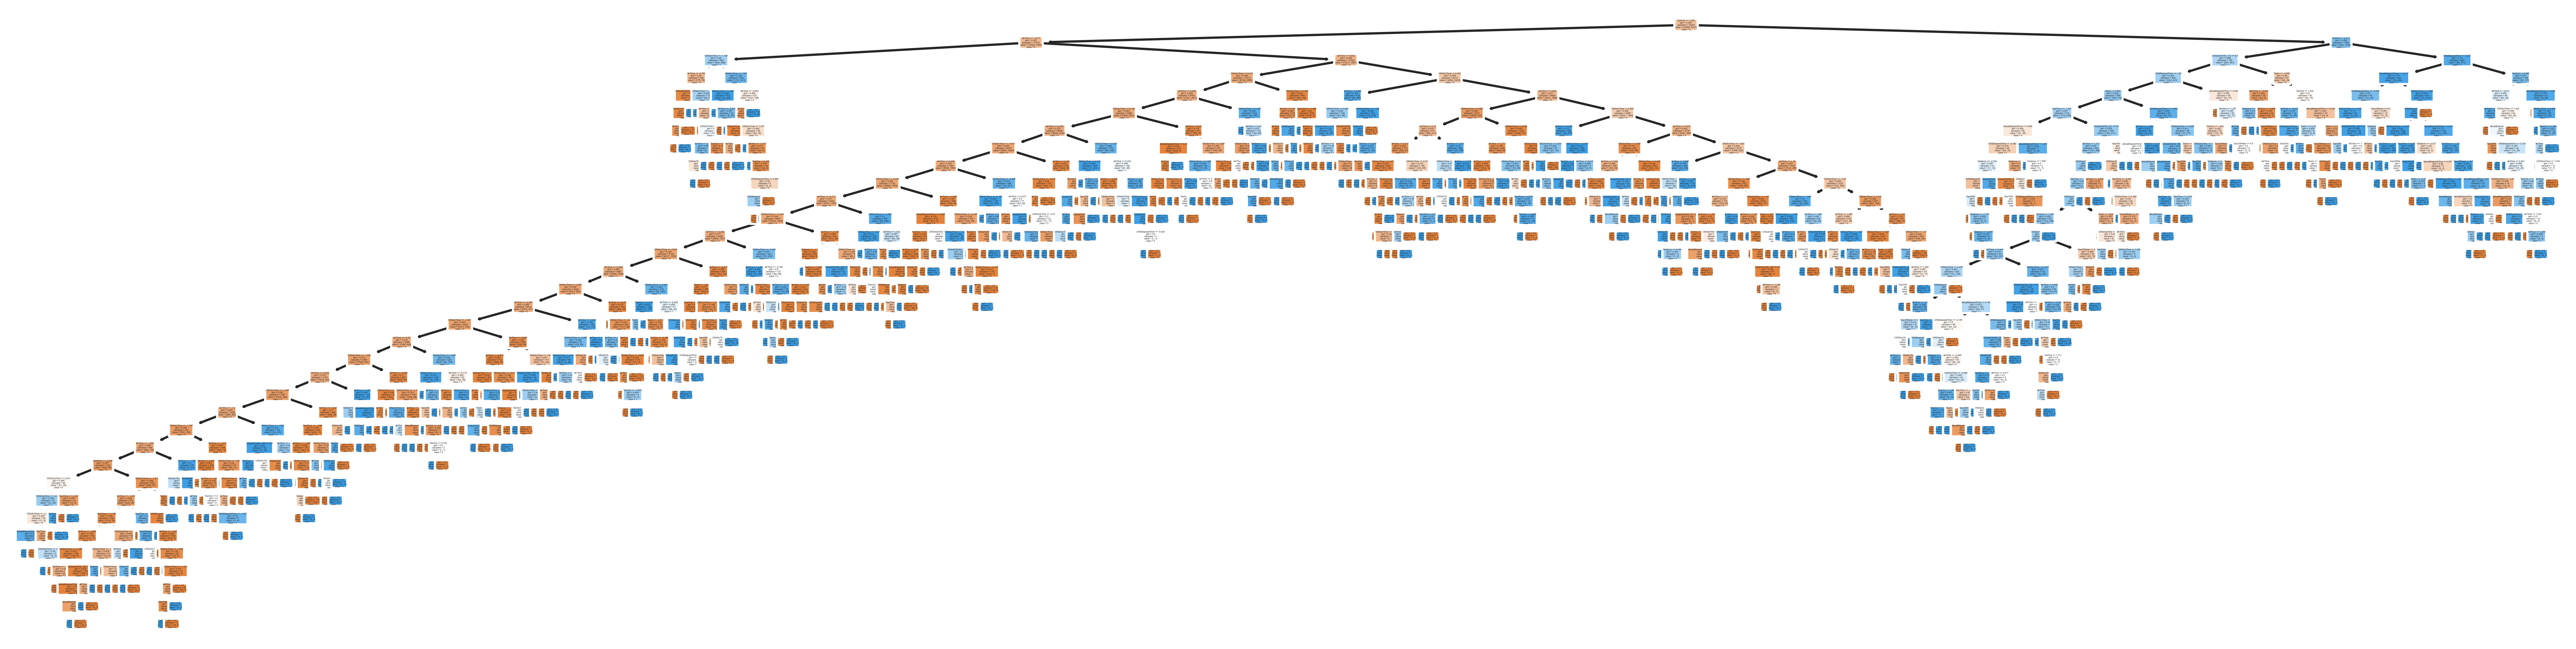

In [23]:
# Visualize Model

plt.figure(figsize=(20, 5), dpi=500)
tree.plot_tree(clf,
               feature_names=feature_cols,
               class_names=["0", "1"],
               filled=True,
               rounded=True);

In [24]:
# Evaluate the model:
# Confusion matrix.
print(metrics.confusion_matrix(y_complete, y_pred))
# Classification Report
print(metrics.classification_report(y_complete, y_pred))

[[12856     0]
 [    0  6427]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     12856
        True       1.00      1.00      1.00      6427

    accuracy                           1.00     19283
   macro avg       1.00      1.00      1.00     19283
weighted avg       1.00      1.00      1.00     19283



In [25]:
# Let's apply k-Fold Cross Validation (CV) with all the data.
accuracies1CV = cross_val_score(estimator = clf, X=X_complete, y=y_complete , cv = 10)
print("Decision Tree Classifier:\n Accuracy: %.3f"%accuracies1CV.mean(), "+/- %.3f"%accuracies1CV.std(),"\n")

Decision Tree Classifier:
 Accuracy: 0.952 +/- 0.007 



#### Observation
Even without the high dependant variable (DepDelay (0.95 correlation)) the model is very good!!.
Accuracy and F1_Sore give us a result of 1 (perfect fit), and CV is 0.952 (better than 0.927 from before execution.

The model has proved to be very good only with the featured variables that we have now.

### 1.2.1.- Create and Visualize KNN - k-Nearest Neighbors Model

In [26]:
# Create KNN classifier object
KNNclassifier = KNeighborsClassifier(n_neighbors=5)
# Train KNN Classifier
KNNclassifier.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = KNNclassifier.predict(X_test)

Text(0, 0.5, 'Mean Error')

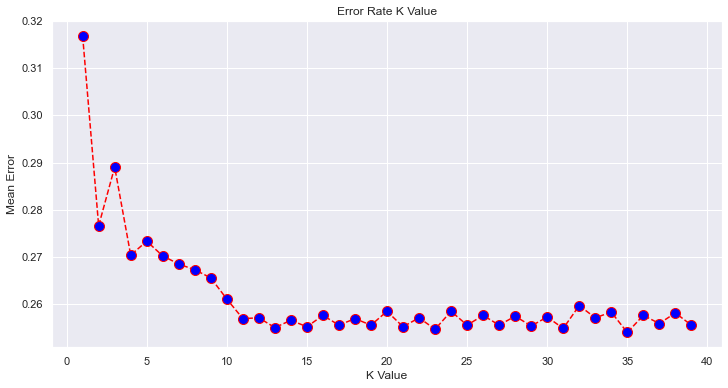

In [27]:
# Visualize Model Error Rate

error = []
# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

### 1.2.2.- Evaluate KNN Model

In [28]:
# Evaluate the model:
# Confusion matrix.
print(metrics.confusion_matrix(y_test, y_pred))
# Classification Report
print(metrics.classification_report(y_test, y_pred))

[[3465  431]
 [1150  739]]
              precision    recall  f1-score   support

       False       0.75      0.89      0.81      3896
        True       0.63      0.39      0.48      1889

    accuracy                           0.73      5785
   macro avg       0.69      0.64      0.65      5785
weighted avg       0.71      0.73      0.71      5785



### 1.2.3.- Optimizing KNN
**n_neighbors** : int, default=5
        Number of neighbors to use by default for :meth:`kneighbors` queries.

In [29]:
KNNclassifier = KNeighborsClassifier(n_neighbors=10) # Create KNN classifier object
KNNclassifier.fit(X_train, y_train) # Train Decision Tree Classifier
y_pred = KNNclassifier.predict(X_test) #Predict the response for test dataset

# Evaluate the model:
# Confusion matrix.
print(metrics.confusion_matrix(y_test, y_pred))
# Classification Report
print(metrics.classification_report(y_test, y_pred))

[[3712  184]
 [1326  563]]
              precision    recall  f1-score   support

       False       0.74      0.95      0.83      3896
        True       0.75      0.30      0.43      1889

    accuracy                           0.74      5785
   macro avg       0.75      0.63      0.63      5785
weighted avg       0.74      0.74      0.70      5785



#### Observation:
In this case, the optimization give us some result.  
A little improvement on Accuracy and F1_Score.

### 1.2.4.- Compare KNN Performance using the trait/test or cross-validation approach.

In [30]:
#Let's concatenate train & test
X_complete = pd.concat([X_train,X_test])
print("X shape:",X_complete.shape)
y_complete = pd.concat([y_train,y_test])
print("y shape:",y_complete.shape)

X shape: (19283, 31)
y shape: (19283,)


In [31]:
# Create KNN classifier object
KNNclassifier = KNeighborsClassifier(n_neighbors=5)
# Train KNN Classifier
KNNclassifier.fit(X_complete, y_complete)
#Predict the response for test dataset
y_pred = KNNclassifier.predict(X_complete)


Text(0, 0.5, 'Mean Error')

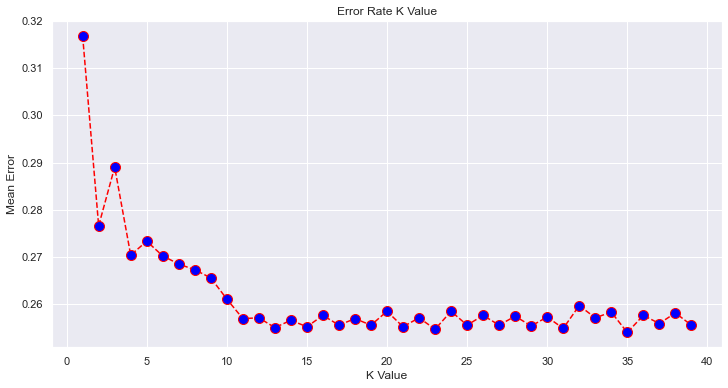

In [32]:
# Visualize Model Error Rate

error = []
# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Classification Report
              precision    recall  f1-score   support

       False       0.80      0.94      0.87     12856
        True       0.82      0.54      0.65      6427

    accuracy                           0.81     19283
   macro avg       0.81      0.74      0.76     19283
weighted avg       0.81      0.81      0.79     19283



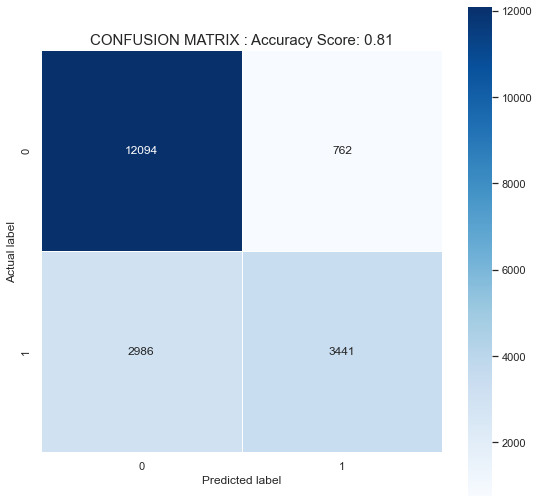

In [33]:
# Evaluate the model:
# Confusion matrix.
score = KNNclassifier.score(X_complete, y_complete)
cm = metrics.confusion_matrix(y_complete, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'CONFUSION MATRIX : Accuracy Score: %.2f'%score
plt.title(all_sample_title, size = 15);
# Classification Report
print("Classification Report")
print(metrics.classification_report(y_complete, y_pred))

In [34]:
# Let's apply k-Fold Cross Validation (CV) with all the data.
accuracies1CV = cross_val_score(estimator = KNNclassifier, X=X_complete, y=y_complete , cv = 10)
print("KNN Classifier:\n Accuracy: %.3f"%accuracies1CV.mean(), "+/- %.3f"%accuracies1CV.std(),"\n")

KNN Classifier:
 Accuracy: 0.724 +/- 0.009 



#### Observation
In KNN model, without the very high dependant variable DepDelay the model is not so good. (0.724 CV accuracy.)   
This was expected in the previous execution.

### 1.3.1.- Create XGBoost Model

In [35]:
# Create XGB classifier object
XBGcClf = xgb.XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')
# Train XGB Classifier
XBGcClf.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = XBGcClf.predict(X_test)

### 1.3.2.- Evaluate XGBoost Model

In [36]:
# Evaluate the model:
# Confusion matrix.
print(metrics.confusion_matrix(y_test, y_pred))
# Classification Report
print(metrics.classification_report(y_test, y_pred))

[[3844   52]
 [ 116 1773]]
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      3896
        True       0.97      0.94      0.95      1889

    accuracy                           0.97      5785
   macro avg       0.97      0.96      0.97      5785
weighted avg       0.97      0.97      0.97      5785



### 1.3.3.- Optimizing XGBoost
Tune max_depth and min_child_weight with Grid Search.

In [37]:
np.set_printoptions(precision=3)
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,use_label_encoder=False,eval_metric='mlogloss'), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
         

In [38]:
print("-----cv_results_-----")
display(gsearch1.cv_results_)
print("-----best_params_-----")
display(gsearch1.best_params_)
print("-----best_score_-----")
display(gsearch1.best_score_)

-----cv_results_-----


{'mean_fit_time': array([1.195, 1.235, 1.217, 1.806, 1.847, 1.7  , 2.527, 2.411, 2.489,
        3.245, 3.001, 2.661]),
 'std_fit_time': array([0.038, 0.137, 0.137, 0.02 , 0.044, 0.007, 0.061, 0.026, 0.115,
        0.034, 0.072, 0.195]),
 'mean_score_time': array([0.012, 0.012, 0.011, 0.012, 0.012, 0.011, 0.012, 0.012, 0.013,
        0.013, 0.013, 0.013]),
 'std_score_time': array([0.001, 0.   , 0.001, 0.002, 0.001, 0.001, 0.001, 0.   , 0.001,
        0.   , 0.001, 0.001]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object),
 'params'

-----best_params_-----


{'max_depth': 9, 'min_child_weight': 1}

-----best_score_-----


0.9952909291004499

#### Observation:  
So, with this GridSearch, we have found that the best params are {'max_depth': 9, 'min_child_weight': 1} and we get and score of 0.995!  
We could continue finding best params tuning gamma // subsample and colsample_bytree // Regularization Parameters or Reducing Learning Rate.  
But this result is already very good!

### 1.3.4.- Compare XGBOOST Performance using the trait/test or cross-validation approach.

In [39]:
#Let's concatenate train & test
X_complete = pd.concat([X_train,X_test])
print("X shape:",X_complete.shape)
y_complete = pd.concat([y_train,y_test])
print("y shape:",y_complete.shape)

X shape: (19283, 31)
y shape: (19283,)


In [40]:
# Create XGB classifier object
XBGcClf = xgb.XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')
# Train XGB Classifier
XBGcClf.fit(X_complete, y_complete)
#Predict the response for test dataset
y_pred = XBGcClf.predict(X_complete)


In [41]:
# Evaluate the model:
# Confusion matrix.
print(metrics.confusion_matrix(y_complete, y_pred))
# Classification Report
print(metrics.classification_report(y_complete, y_pred))

[[12854     2]
 [   12  6415]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     12856
        True       1.00      1.00      1.00      6427

    accuracy                           1.00     19283
   macro avg       1.00      1.00      1.00     19283
weighted avg       1.00      1.00      1.00     19283



In [42]:
# Let's apply k-Fold Cross Validation (CV) with all the data.
accuracies1CV = cross_val_score(estimator = XBGcClf, X=X_complete, y=y_complete , cv = 10)
print("XGB Classifier:\n Accuracy: %.3f"%accuracies1CV.mean(), "+/- %.3f"%accuracies1CV.std(),"\n")

XGB Classifier:
 Accuracy: 0.975 +/- 0.004 



#### Observation
The model improves using the complete data.
Even without the high dependant variable DepDelay the model is very, very good! (CV Accuracy 0.975).
This result wasn't expected but we are glad to find it out.